In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = pd.read_csv(r"C:\Users\Administrator\Desktop\Jupyter Notebook\Data\北京PM2.5浓度数据集\pm25_train.csv")
test_data = pd.read_csv(r"C:\Users\Administrator\Desktop\Jupyter Notebook\Data\北京PM2.5浓度数据集\pm25_test.csv")

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35746 entries, 0 to 35745
Data columns (total 13 columns):
date       35746 non-null object
hour       35746 non-null int64
pm2.5      35746 non-null float64
DEWP       35746 non-null int64
TEMP       35746 non-null float64
PRES       35746 non-null float64
Iws        35746 non-null float64
Is         35746 non-null int64
Ir         35746 non-null int64
cbwd_NE    35746 non-null int64
cbwd_NW    35746 non-null int64
cbwd_SE    35746 non-null int64
cbwd_cv    35746 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 3.5+ MB


In [5]:
train_data.head(3)

,date,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,2010-01-02,0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
1,2010-01-02,1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2,2010-01-02,2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0


In [6]:
#数据处理
train_data["year"] = pd.to_datetime(train_data["date"]).dt.year # 年
train_data["month"] = pd.to_datetime(train_data["date"]).dt.month # 月
train_data["day"] = pd.to_datetime(train_data["date"]).dt.day # 日
train_data["weekday"] = pd.to_datetime(train_data["date"]).dt.weekday # 星期

test_data["year"] = pd.to_datetime(test_data["date"]).dt.year
test_data["month"] = pd.to_datetime(test_data["date"]).dt.month
test_data["day"] = pd.to_datetime(test_data["date"]).dt.day
test_data["weekday"] = pd.to_datetime(test_data["date"]).dt.weekday

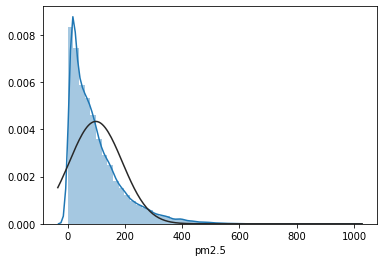

In [7]:
#正态检验
from scipy.stats import norm
import seaborn as sns
sns.distplot(train_data["pm2.5"],fit=norm)

((array([-4.11462207, -3.90523093, -3.79092845, ...,  3.79092845,
          3.90523093,  4.11462207]),
  array([  0.,   0.,   1., ..., 972., 980., 994.])),
 (84.02522453800752, 98.80509707379844, 0.9131604895345479))

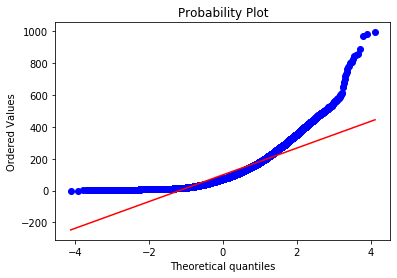

In [8]:
from scipy import stats
stats.probplot(train_data['pm2.5'],plot=plt)

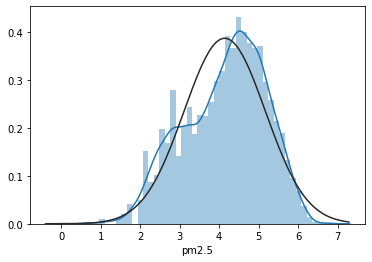

In [9]:
train_data.drop(train_data[train_data["pm2.5"] == 0].index,inplace=True)
sns.distplot(np.log(train_data["pm2.5"]),fit=norm)

((array([-4.11460917, -3.9052174 , -3.79091455, ...,  3.79091455,
          3.9052174 ,  4.11460917]),
  array([0.        , 0.        , 0.        , ..., 6.8793558 , 6.88755257,
         6.90173721])),
 (1.020390331382008, 4.140573453325116, 0.9899406951492453))

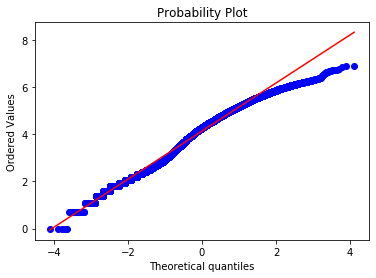

In [10]:
stats.probplot(np.log(train_data['pm2.5']),plot=plt)

In [11]:
train_data["log_pm2.5"] = np.log(train_data['pm2.5'])

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [13]:
#平台特征标签分离
features = [ 'hour',  'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
       'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'year', 'month', 'day',
       'weekday']
labels = "log_pm2.5"

In [14]:
#划分训练集与测试集
X_train,X_test,Y_train,Y_test = train_test_split(train_data[features],train_data[labels],test_size=0.2,random_state = 10)

In [15]:
#训练模型
model = LinearRegression()
model.fit(X_train,Y_train)
pre = model.predict(X_test)

In [16]:
mean_squared_error(pre,Y_test)

0.6169782885037971

In [17]:
r2_score(Y_test,pre) #拟合度

0.4214605730380332

In [18]:
#Lasso回归
from sklearn.linear_model import Lasso,LassoCV

In [19]:
Lambdas=np.logspace(-10,2,2000)
lasso_cv=LassoCV(alphas=Lambdas,normalize=True,cv=10,max_iter=10000)
lasso_cv.fit(X_train,Y_train)
lasso_cv.alpha_

1.86911411820748e-07

In [20]:
lasso=Lasso(alpha=lasso_cv.alpha_,normalize=True,max_iter=10000)
lasso.fit(X_train,Y_train)
lasso_pre=lasso.predict(X_test)

In [21]:
mean_squared_error(Y_test,lasso_pre)

0.6169769006613242

In [22]:
r2_score(Y_test,lasso_pre)

0.42146187441541383

In [23]:
print(pd.Series(index=['Intercept']+X_train.columns.tolist(),
                data=[lasso.intercept_]+lasso.coef_.tolist()))

Intercept    55.253721
hour          0.012310
DEWP          0.055657
TEMP         -0.076257
PRES         -0.020764
Iws          -0.003627
Is           -0.026637
Ir           -0.079902
cbwd_NE      -0.394258
cbwd_NW      -0.447996
cbwd_SE       0.136994
cbwd_cv       0.000000
year         -0.014454
month        -0.016871
day           0.006179
weekday       0.013773
dtype: float64


In [24]:
#岭回归
from sklearn.linear_model import Ridge,RidgeCV

In [25]:
lambdas = np.logspace(-5,2,200)

In [26]:
ridge_cv = RidgeCV(alphas=lambdas,normalize=True,scoring="neg_mean_squared_error",cv=10)
ridge_cv.fit(X_train,Y_train)
ridge_cv.alpha_

5.478901179593945e-05

In [27]:
model=Ridge(alpha=ridge_cv.alpha_,normalize=True)
model.fit(X_train,Y_train)
ridge_pre = model.predict(X_test)

In [28]:
mean_squared_error(Y_test,ridge_pre)

0.6169759952335255

In [29]:
r2_score(Y_test,ridge_pre)

0.4214627234334255